# Upstage House Price Prediction | 아파트 실거래가 예측 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Result


## 1. Library Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import random

import lightgbm as lgb
from sklearn.metrics import mean_squared_error


## 2. Data Load

#### 2.1 데이터 로드
- 시군구, 도로명 정보를 기반으로 카카오 지도 API를 활용하여 좌표(X, Y)를 보완한 데이터셋을 로드하였다.
- 좌표 보완 과정에 대한 세부 구현은 fillcoords.ipynb 파일을 참고한다.

In [2]:
train_path = "../data/dt_coord.csv"
test_path  = "../data/dt_test_coord.csv"

dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

#### 2.2 데이터 탐색
- 데이터 탐색 단계에서는 전체 데이터의 규모, 변수 구성, 변수 간 분포 특성 등을 확인하여 이후 전처리 및 모델링 방향을 설정하였다.

In [3]:
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)
print("Train Test ratio:", dt_test.shape[0]/dt.shape[0])

Train data shape :  (1109340, 52) Test data shape :  (9272, 51)
Train Test ratio: 0.008358122847819425


In [4]:
print(len(dt.columns),"가지의 변수들")
print(dt.columns)

print(len(dt_test.columns),"가지의 변수들")
print(dt_test.columns)

52 가지의 변수들
Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')
51 가지의 변수들
Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적'

In [5]:
print("변수별 종류 수")
for variable in dt.columns:
    print(variable,":", len(dt[variable].unique()))


변수별 종류 수
시군구 : 338
번지 : 6530
본번 : 1523
부번 : 329
아파트명 : 6486
전용면적(㎡) : 14545
계약년월 : 198
계약일 : 31
층 : 73
건축년도 : 60
도로명 : 9140
해제사유발생일 : 1026
등기신청일자 : 182
거래유형 : 3
중개사소재지 : 643
k-단지분류(아파트,주상복합등등) : 6
k-전화번호 : 1542
k-팩스번호 : 1665
단지소개기존clob : 95
k-세대타입(분양형태) : 4
k-관리방식 : 4
k-복도유형 : 6
k-난방방식 : 5
k-전체동수 : 42
k-전체세대수 : 522
k-건설사(시공사) : 345
k-시행사 : 556
k-사용검사일-사용승인일 : 674
k-연면적 : 735
k-주거전용면적 : 740
k-관리비부과면적 : 736
k-전용면적별세대현황(60㎡이하) : 349
k-전용면적별세대현황(60㎡~85㎡이하) : 388
k-85㎡~135㎡이하 : 245
k-135㎡초과 : 2
k-홈페이지 : 222
k-등록일자 : 127
k-수정일자 : 744
고용보험관리번호 : 527
경비비관리형태 : 5
세대전기계약방법 : 3
청소비관리형태 : 5
건축면적 : 456
주차대수 : 527
기타/의무/임대/임의=1/2/3/4 : 5
단지승인일 : 736
사용허가여부 : 2
관리비 업로드 : 3
좌표X : 9114
좌표Y : 9114
단지신청일 : 260
target : 14361


## 3. Data Preprocessing

#### 3.1. 결측치 탐색 및 보간
- 본 데이터는 완전 예측 관점에서 제외 가능한 변수는 분석 대상에서 제거하였다.
- 결측값이 존재하는 변수는 Train 데이터에서 우선적으로 제거하였으며, 동일한 변수 제거 기준을 Test 데이터에도 일관되게 적용하였다.
- 이를 통해 학습 및 예측 단계에서 결측치로 인한 불확실성을 최소화하였다.

In [6]:
dt["거래유형"] = dt["거래유형"].replace("-", np.nan)
dt["등기신청일자"] = dt["등기신청일자"].replace(" ", np.nan)
dt["중개사소재지"] = dt["중개사소재지"].replace("-", np.nan)

drop_cols = dt.columns[dt.isna().sum() > 0]
dt = dt.drop(columns=drop_cols)
dt_test = dt_test.drop(columns=drop_cols)


#### 3.2. 이상치 처리
- 이상치 탐지를 위해 주요 수치형 변수의 분포 범위를 확인하였다.
- IQR 기준 이상치 비율은 최대 7.98% 수준으로 확인되었으며, 전용면적, 층m 건축년도와 같은 핵심 변수의 경우 도메인 특성상 자연스럽게 넓은 범위를 가질 수 있다고 판단하여 이상치를 제거하지 않았다.
- 또한 아파트 가격은 위치, 평수, 층수 등 다양한 요인으로 인해 값의 분산이 크게 나타날 수 있으므로, 이상치를 단순 제거하는 방식은 적용하지 않았다.


In [7]:
num_cols = [
    '전용면적(㎡)',
    '층',
    '건축년도'
]

dt[num_cols].describe().round(2)

,전용면적(㎡),층,건축년도
count,1109340.00,1109340.00,1109340.00
mean,77.24,8.91,1998.88
std,29.38,5.99,9.25
min,10.02,-4.00,1961.00
25%,59.67,4.00,1993.00
50%,82.19,8.00,2000.00
75%,84.96,12.00,2005.00
max,424.32,69.00,2023.00


## 4. Feature Engineering
- 부동산 가격은 지역적 요인과 거래 시점의 영향을 크게 받는 특성이 있다.
- 이에 따라 공간 정보와 시간 정보를 분리, 가공하여 모델 학습에 활용하였다.



#### 4.1. 지역, 시간 변수 분해
- 시군구 변수에서 구, 동 정보를 분리하여 각각 독립적인 변수로 생성하였다.
- 계약년월 변수는 계약년도와 계약월로 분해하여 시간적 패턴을 명확히 반영하도록 하였다.

In [8]:
dt['구'] = dt['시군구'].map(lambda x : x.split()[1])
dt['동'] = dt['시군구'].map(lambda x : x.split()[2])
del dt['시군구']

dt['계약년'] = dt['계약년월'].astype('str').map(lambda x : x[:4])
dt['계약월'] = dt['계약년월'].astype('str').map(lambda x : x[4:])

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
del dt_test['시군구']

dt_test['계약년'] = dt_test['계약년월'].astype('str').map(lambda x : x[:4])
dt_test['계약월'] = dt_test['계약년월'].astype('str').map(lambda x : x[4:])


#### 4.2 지역 파생 변수 생성

- 서울 지역의 경우 강남권과 비강남권 간 가격 차이가 뚜렷하게 존재한다는 점에 착안하여, 강남권 여부 이진 변수로 생성하였다.

In [9]:
gangnam = ["강서구","영등포구","동작구","서초구","강남구","송파구","강동구"]
dt["강남여부"] = dt["구"].isin(gangnam).astype(int)
dt_test["강남여부"] = dt_test["구"].isin(gangnam).astype(int)

#### 4.3 건축 연식 관련 변수

- 신축 여부 또한 주택 가격에 중요한 영향을 미칠 수 있으므로,2009년을 기준으로 신축 여부를 판단하는 파생 변수를 추가하였다.

In [10]:
dt["신축여부"] = (dt["건축년도"] >= 2009).astype(int)
dt_test["신축여부"] = (dt_test["건축년도"] >= 2009).astype(int)

## 5. Model Training

#### 5.1 Modeling Dataset 구성

- 전처리 및 파생변수 생성을 완료한 데이터를 기반으로 최종 모델링 데이터셋을 구성하였다.
- 예측 대상인 target을 포함하여 학습 및 추론에 필요한 변수만을 선별하였다.

In [11]:
dt_test["target"] = 0

features = [
    "계약년월","계약년","계약월","계약일",
    "건축년도","신축여부",
    "구","동","도로명",
    "좌표X","좌표Y",
    "강남여부","전용면적(㎡)","층","target"
]

dt = dt[features]
dt_test = dt_test[features]


#### 5.2. 시계열 Validation Split
- 데이터의 시계열 특성을 고려하여 계약년월 기준 분할을 적용하였다.
- 2022년 6월 이전 데이터를 Train 데이터로 사용, 이후 데이터를 Validation 데이터로 분리하였다. 
- 이를 통해 미래 시점을 예측하는 실제 상황과 유사한 검증 환경을 구축하였다.

In [13]:
train_mask = dt["계약년월"] <= 202206

X_train = dt.loc[train_mask].drop("target", axis=1)
y_train = dt.loc[train_mask, "target"]

X_val = dt.loc[~train_mask].drop("target", axis=1)
y_val = dt.loc[~train_mask, "target"]

X_test = dt_test.drop("target", axis=1)


drop_cols = ['계약년월', '계약일']

X_train = X_train.drop(drop_cols, axis=1)
X_val   = X_val.drop(drop_cols, axis=1)
X_test  = X_test.drop(drop_cols, axis=1)




#### 5.3 dtype 정리 (LightGBM용)
- 여러 모델 비교 결과, LightGBM 모델이 가장 우수한 성능을 보였다.
- 시간 관련 변수는 정수형(int)으로 변환하며, 지역 관련 범주형 변수는 category 타입으로 유지하여 LightGBM의 범주형 처리 기능을 활용하였다.

In [14]:
categorical_cols = ["구","동","도로명"]

for col in ["계약년","계약월"]:
    X_train[col] = X_train[col].astype(int)
    X_val[col]   = X_val[col].astype(int)
    X_test[col]  = X_test[col].astype(int)

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_val[col]   = X_val[col].astype("category")
    X_test[col]  = X_test[col].astype("category")


In [16]:
X_train.head()

,계약년,계약월,건축년도,신축여부,구,동,도로명,좌표X,좌표Y,강남여부,전용면적(㎡),층
0,2017,12,1987,0,강남구,개포동,언주로 3,127.05721,37.476763,1,79.97,3
1,2017,12,1987,0,강남구,개포동,언주로 3,127.05721,37.476763,1,79.97,4
2,2017,12,1987,0,강남구,개포동,언주로 3,127.05721,37.476763,1,54.98,5
3,2018,1,1987,0,강남구,개포동,언주로 3,127.05721,37.476763,1,79.97,4
4,2018,1,1987,0,강남구,개포동,언주로 3,127.05721,37.476763,1,79.97,2


#### 5.4 Train + Validation Merge 
- 최종 학습 단계에서는 Train 데이터와 Validation 데이터를 병합하여 전체 학습 데이터셋을 구성한 뒤 모델을 재학습하였다


In [17]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

for col in categorical_cols:
    X_full[col] = X_full[col].astype("category")



#### 5.5 LightGBM Hyperparameter Loop
- LightGBM 모델의여러 모델을 비교하였으며, 가장 성과가 좋아 선정하였다. (Modelchoice.ipynb 참고)
- 다양한 하이퍼파라미터 조합을 반복적으로 실험하여 모델을 학습하였으며, 각 실험 결과에 대해 Validation 성능과 Test 예측 결과를 모두 저장하였다.

In [60]:
N_TRIALS = 100
random.seed(42)

param_space = {
    "num_leaves":       [39,47,55,63,71,79],
    "max_depth":        [12,13,14],
    "learning_rate":    [0.052,0.055,0.058],
    "min_data_in_leaf": [5,6,8,10,12],
    "feature_fraction": [0.75,0.8],
    "bagging_fraction": [0.85,0.9],
    "bagging_freq":     [2,3],
    "lambda_l1":        [0.0],
    "lambda_l2":        [0.0],
}

for trial in range(1, N_TRIALS+1):

    params = {k: random.choice(v) for k,v in param_space.items()}

    model = lgb.LGBMRegressor(
        n_estimators=1500,
        objective="regression",
        random_state=42,
        **params
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val,y_val)],
        eval_metric="rmse",
        categorical_feature=categorical_cols,
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    final_model = lgb.LGBMRegressor(
        n_estimators=1500,
        objective="regression",
        random_state=42,
        **params
    )

    final_model.fit(
        X_full, y_full,
        categorical_feature=categorical_cols
    )

    test_pred = final_model.predict(X_test)

    submission = pd.DataFrame({
        "target": test_pred.round().astype(int)
    })

    fname = (
        f"submission_trial_{trial:03d}_"
        f"rmse_{int(rmse)}_"
        f"leaves_{params['num_leaves']}_"
        f"depth_{params['max_depth']}_"
        f"lr_{params['learning_rate']}.csv"
    )

    submission.to_csv(fname, index=False)
    print(f"✅ Saved {fname}")
    print("-" * 80)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: 

## 6. Interpretation

- 본 절에서는 TEST RMSE 수치가 가장 좋은 
`submission_trial_032_rmse_22154_leaves_47_depth_14_lr_0.058.csv`  
를 생성한 LightGBM 모델을 기준으로 변수별 인사이트를 도출하였다.

#### 6.1 Model Interpretation

- Validation 성능이 가장 우수한 모델이 항상 Test 성능에서도 최적의 결과를 보장하지는 않았다.  
- 실험 결과, 상대적으로 단순한 구조를 가진 모델이 Test RMSE 기준에서 가장 안정적인 일반화 성능을 보였다.  
- **Public Test RMSE: 14,973.0670**  
- **Private Test RMSE: 11,847.0515**
  

- **모델 설명**  
  boosting_type = `gbdt`, objective = `regression`  
  Gradient Boosting Decision Tree(GBDT) 기반 회귀 모델을 사용하여 연속형 변수인 아파트 실거래가를 예측하도록 설계하였다. 
  비선형 관계와 변수 간 상호작용을 효과적으로 학습할 수 있다는 점에서 부동산 가격 예측 문제에 적합한 모델이다.

- **모델 복잡도 설정**  
  num_leaves = 47, max_depth = 14  
  트리의 최대 깊이와 leaf 개수를 제한하여 모델 복잡도를 중간 수준으로 유지하였다. 과도한 분기 생성을 방지하면서도 충분한 표현력을 확보하기 위한 설정이다.

- **학습 안정성 확보**  
  learning_rate = 0.058, n_estimators = 1500  
  상대적으로 작은 learning rate와 충분한 트리 개수를 조합하였다. 위 복잡도에서 좋은 성과를 보였고 점진적으로 학습하면서 안정적인 수렴을 유도하였다.

- **과적합 방지 전략**  
  feature_fraction = 0.75, bagging_fraction = 0.9, bagging_freq = 3, min_data_in_leaf = 8  
  각 트리 학습 시 일부 feature와 샘플만을 사용하도록 설정하여 트리 간 상관성을 줄이고 과적합을 방지하였다. 또한 leaf 단위의 최소 데이터 수를 제한하여 노이즈에 민감한 분기를 억제하였다.

- **정규화 전략**  
  lambda_l1 = 0.0, lambda_l2 = 0.0  
  명시적인 L1/L2 정규화보다는 트리 구조 제약과 샘플링 전략을 통해 모델 복잡도를 제어하는 방식을 채택하였다.


In [18]:
final_params = {
    "num_leaves": 47,
    "max_depth": 14,
    "learning_rate": 0.058,
    "min_data_in_leaf": 8,
    "feature_fraction": 0.75,
    "bagging_fraction": 0.9,
    "bagging_freq": 3,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
}

final_model = lgb.LGBMRegressor(
    n_estimators=1500,
    objective="regression",
    random_state=42,
    **final_params
)

final_model.fit(
    X_full, y_full,
    categorical_feature=categorical_cols
)


[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: la

,boosting_type,'gbdt'
,num_leaves,47
,max_depth,14
,learning_rate,0.058
,n_estimators,1500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### 6.2 Feature Importance 


- 분석 결과, 가격 예측에 가장 큰 영향을 미친 변수는 `동(31.86%)`, `전용면적(㎡)(22.24%)`, `계약년(19.22%)`, `도로명(17.95%)`, `구(5.39%)` 순으로 나타났다. 상위 5개 변수만으로 전체 중요도의 약 94.6%를 차지하여, 아파트 가격 결정 요인이 소수의 핵심 변수에 집중되어 있음을 확인하였다.

- 특히 `동`과 `도로명`과 같은 미시적 입지 변수의 중요도가 매우 높게 나타났는데, 이는 동일 구 내에서도 세부 입지에 따라 가격 차이가 크게 발생하는 서울 아파트 시장의 특성을 반영한 결과로 해석된다. 반면, `강남여부`와 같은 이진 요약 변수의 중요도는 상대적으로 낮았으며, 이는 강남 프리미엄이 이미 동·도로명 변수에 충분히 반영되어 있기 때문으로 판단된다.

- 또한 `전용면적(㎡)`은 물리적 특성 중 가장 중요한 변수로 확인되었으며, 면적이 클수록 가격이 상승하는 구조적 관계가 모델에 의해 일관되게 학습되었다. `계약년` 변수는 시계열적 시장 환경과 가격 변동 흐름을 반영하는 역할을 수행하였다.

종합적으로 본 모델은 입지, 면적, 거래 시점이라는 부동산 가격 결정의 핵심 요인을 효과적으로 학습하였으며, 특히 입지 중심의 가격 결정 구조가 두드러지게 나타났다.


In [21]:
importance_df = pd.DataFrame({
    "feature": X_full.columns,
    "importance_gain": final_model.booster_.feature_importance(
        importance_type="gain"
    )
})

# 퍼센트 계산
importance_df["importance_pct"] = (
    importance_df["importance_gain"]
    / importance_df["importance_gain"].sum()
    * 100
)

# 중요도 순 정렬
importance_df = importance_df.sort_values(
    "importance_pct", ascending=False
)

importance_df


,feature,importance_gain,importance_pct
5,동,6.054016e+15,31.855112
10,전용면적(㎡),4.227263e+15,22.243074
0,계약년,3.653534e+15,19.224219
6,도로명,3.412046e+15,17.953554
4,구,1.025388e+15,5.395402
2,건축년도,3.270491e+14,1.720872
11,층,8.691636e+13,0.457338
1,계약월,7.074147e+13,0.372229
8,좌표Y,6.395554e+13,0.336522
3,신축여부,4.439246e+13,0.233585


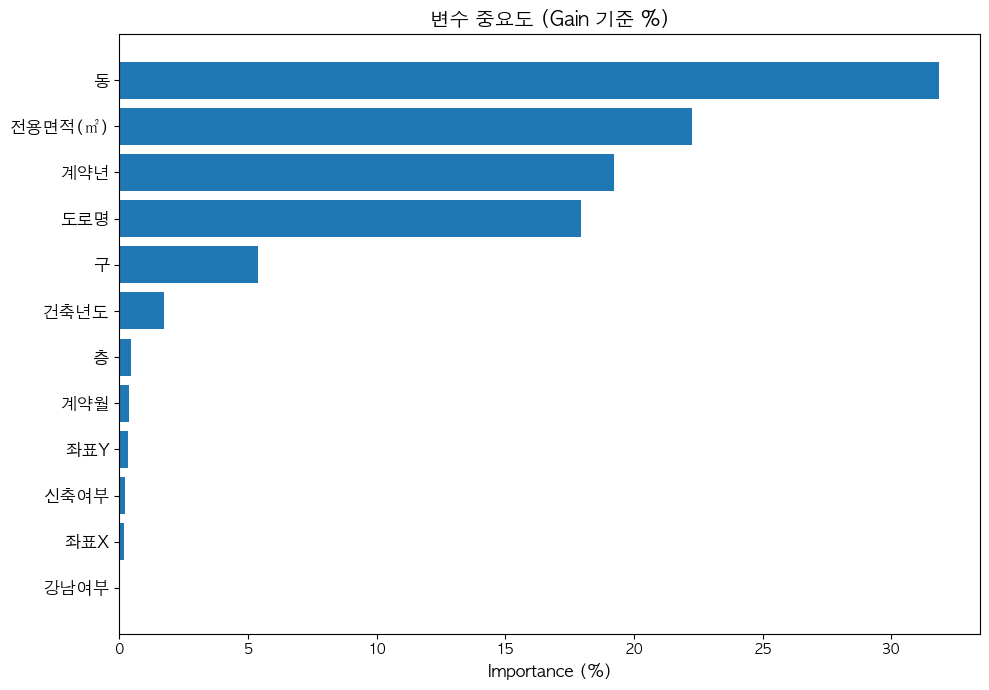

In [20]:
importance_df = pd.DataFrame({
    "feature": X_full.columns,
    "importance_gain": final_model.booster_.feature_importance(
        importance_type="gain"
    )
}).sort_values("importance_gain", ascending=False)

importance_df["importance_pct"] = (
    importance_df["importance_gain"]
    / importance_df["importance_gain"].sum()
    * 100
)

font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
font = font_manager.FontProperties(fname=font_path)
rc("font", family=font.get_name())
plt.rcParams["axes.unicode_minus"] = False

features = importance_df["feature"][:15][::-1]
values = importance_df["importance_pct"][:15][::-1]

plt.figure(figsize=(10, 7))
plt.barh(range(len(features)), values)

plt.yticks(
    range(len(features)),
    features,
    fontsize=12
)

plt.xlabel("Importance (%)", fontsize=12)
plt.title("변수 중요도 (Gain 기준 %)", fontsize=14)
plt.tight_layout()
plt.show()

#### 6.3. RMSE Inference

- Public RMSE가 낮다고 해서 Private RMSE 성능이 반드시 우수하지 않다는 점을 확인하였다.
- 이에 따라 단일 지표에 의존하기보다는 전반적인 일반화 성능을 기준으로 모델을 선택하였다.

(submission_trial_032_rmse_22154_leaves_47_depth_14_lr_0.058.csv)
- Public Test RMSE: 14973.0670
- Private Test RMSE: 11847.0515

(submission_trial_022_rmse_20618_leaves_255_depth_10_lr_0.05.csv)
- Public Test RMSE: 15615.8362
- Private Test RMSE: 11710.0239